# Сборный проект

В данной работе мы исследуем исторические данные о
продажах игр, оценки пользователей и экспертов, жанры и платформы
(например, Xbox или PlayStation), а также выявляем определяющие успешность игры закономерности.

## Изучение информации о файле

Для начала импортируем нужные библиотеки.



In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py

In [ ]:
import warnings

warnings.simplefilter('ignore') 

Затем откроем файл и просмотрим информацию о датафрейме.

In [ ]:
df = pd.read_csv('/datasets/games.csv')
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Всего видим 11 столбцов, 16715 строк. Пропусков не очень много, данные на первый взгляд представлены достаточно полно для анализа.

## Подготовка данных

### Преобразование названий столбцов

Начнем с упорядочивания названий столбцов - приведем их к нижнему регистру. 

In [ ]:
df.columns = df.columns.str.lower()

### Пропуски

**Name**

В столбце с названием игры пропусков всего два, игры эти достаточно старые, а информации по ним почти нет.Это незначительная часть датасета, поэтому просто удалим строки.

In [ ]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [ ]:
df = df.dropna(subset=['name'])
df.reset_index(drop=True, inplace=True)

In [ ]:
print('В таблице содержатся данные о {} играх.'.format(df['name'].nunique()))

В таблице содержатся данные о 11559 играх.


Названий игр меньше, чем строк в таблице, значит, некоторые игры выходят сразу на нескольких платформах.

In [ ]:
display(df[df.duplicated(subset='name')].sort_values(by='name', ascending=True))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3861,Frozen: Olaf's Quest,DS,2013.0,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
9506,007: Quantum of Solace,DS,2008.0,Action,0.11,0.01,0.00,0.01,65.0,tbd,T
4474,007: Quantum of Solace,PS2,2008.0,Action,0.17,0.00,0.00,0.26,NaN,NaN,NaN
1784,007: Quantum of Solace,PS3,2008.0,Action,0.43,0.51,0.02,0.19,65.0,6.6,T
3119,007: Quantum of Solace,Wii,2008.0,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
...,...,...,...,...,...,...,...,...,...,...,...
12647,pro evolution soccer 2011,PC,2010.0,Sports,0.00,0.05,0.00,0.01,79.0,NaN,NaN
3303,pro evolution soccer 2011,X360,2010.0,Sports,0.09,0.44,0.00,0.07,79.0,5.9,E
4663,pro evolution soccer 2011,PS2,2010.0,Sports,0.04,0.21,0.05,0.11,NaN,6.7,E
2582,pro evolution soccer 2011,PSP,2010.0,Sports,0.05,0.30,0.29,0.16,74.0,5.8,E


**Platform**

Узнаем, какие платформы представлены в датафрейме.

In [ ]:
display(df['platform'].unique())
print('Всего в таблице представлены данные по играм для {} платформ.'.format(df['platform'].nunique()))

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Всего в таблице представлены данные по играм для 31 платформ.


In [ ]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

**Year of release**

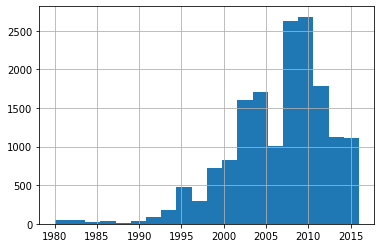

In [ ]:
df['year_of_release'].hist(bins=20)

In [ ]:
df['year_of_release'].isna().sum()

269

В столбце с годом выпуска игры 269 пропусков. Попробуем заменить некоторые из них годами выпуска игр с такими же названиями, но на других платформах.

In [ ]:
for i in df[df['year_of_release'].isna() == True].index:  
    df['year_of_release'][i] = df[df['name'] == df['name'][i]]['year_of_release'].max()

In [ ]:
df['year_of_release'].isna().sum()

146

In [ ]:
df = df.dropna(subset=['year_of_release'])
df.reset_index(drop=True, inplace=True)

Пропусков стало меньше, оставшихся уже не так много, так что можем их просто удалить.

**Critic score**

In [ ]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 13.])

Оценки критиков рассчитаны по 100-балльной шкале, а пропусков в столбце слишком много, чтобы чтобы удалять данные. Мы не можем подобрать подходящие значения для замены, но для удобства возможных дальнейших расчетов заменим пропуски аномально большими цифрами. При расчетах нужно будет не забыть не принимать их во внимание.

In [ ]:
df['critic_score'].isna().sum()

8492

In [ ]:
df['critic_score'] = df['critic_score'].fillna(1000)

**User score**

In [ ]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [ ]:
df['user_score'].isna().sum()

6633

Оценки пользователей рассчитаны по 10-балльной шкале, а пропусков в столбце слишком много, чтобы чтобы удалять данные. Также среи оценок есть значение 'tbd' - видимо, это значит 'to be determined'(англ. "будет определено"). Заменять эти данные по своему усмотрению не получится, приравняем их к пропускам.
Мы не можем подобрать подходящие значения для замены, но для удобства возможных дальнейших расчетов заменим пропуски аномально большими цифрами. При расчетах нужно будет не забыть не принимать их во внимание.

In [ ]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = 100

In [ ]:
df['user_score'] = df['user_score'].fillna(100)

**Rating**

In [ ]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [ ]:
df['rating'].value_counts()

E       3958
T       2930
M       1554
E10+    1412
EC         8
K-A        3
RP         2
AO         1
Name: rating, dtype: int64

In [ ]:
df['rating'].isna().sum()

6699

В этом столбце также много пропусков, но так как они не количественные, на дальнейшие расчеты они не повлияют. Оставим все как есть.

In [ ]:
df.duplicated().sum()

0

### Изменение типов данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16567 entries, 0 to 16566
Data columns (total 11 columns):
name               16567 non-null object
platform           16567 non-null object
year_of_release    16567 non-null float64
genre              16567 non-null object
na_sales           16567 non-null float64
eu_sales           16567 non-null float64
jp_sales           16567 non-null float64
other_sales        16567 non-null float64
critic_score       16567 non-null float64
user_score         16567 non-null object
rating             9868 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Для удобства и наглядности поменяем тип данных в столбце с годом выпуска - на целочисленное, а также в данных с оценкой пользователей, так как нам будет удобнее с количественным значением.

In [ ]:
df['year_of_release'] = df['year_of_release'].astype(int)

In [ ]:
df['user_score'] = df['user_score'].astype(float)

### Общие продажи

Добавим столбец с суммой всех продаж, сложив имеющиеся у нас цифры.

In [ ]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [ ]:
df.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
12154,Interactive Storybook DS Series 1,DS,2007,Misc,0.06,0.00,0.00,0.00,1000.0,100.0,E,0.06
14741,AMNESIA World,PSV,2014,Adventure,0.00,0.00,0.03,0.00,1000.0,100.0,NaN,0.03
14916,Final Fantasy XIV: Heavensward,PC,2015,Action,0.01,0.01,0.00,0.00,86.0,7.7,T,0.02
8186,The Idolm@ster: Shiny Festa - Honey Sound / Fu...,PSP,2012,Action,0.00,0.00,0.17,0.00,1000.0,100.0,NaN,0.17
3859,Sonic & All-Stars Racing Transformed,WiiU,2012,Racing,0.19,0.26,0.02,0.04,1000.0,100.0,NaN,0.51
4544,Big Strike Bowling,PS,2003,Sports,0.23,0.16,0.00,0.03,1000.0,100.0,NaN,0.42
14342,Super Meat Boy: Ultra Edition!,PC,2011,Platform,0.00,0.02,0.00,0.01,1000.0,100.0,NaN,0.03
9170,Monster Lab,DS,2008,Role-Playing,0.12,0.01,0.00,0.01,75.0,100.0,E10+,0.14
11191,Great Party Games,Wii,2010,Misc,0.00,0.07,0.00,0.01,1000.0,100.0,NaN,0.08
8810,187: Ride or Die,PS2,2005,Racing,0.07,0.06,0.00,0.02,52.0,6.8,M,0.15


Данные готовы к анализу - мы убрали многие пропуски, изменили типы данных, где было нужно, добавили сумму продаж.

## Исследовательский анализ данных

### **Данные по годам выпуска**

Text(0, 0.5, 'количество игр')

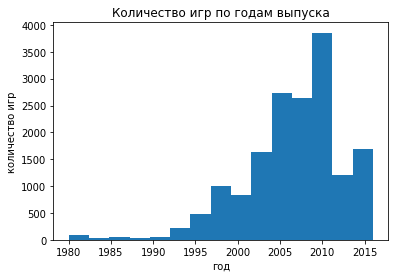

In [ ]:
df['year_of_release'].plot(kind='hist', bins=15, title='Количество игр по годам выпуска')
plt.xlabel("год")
plt.ylabel("количество игр")

Text(0.5, 0, 'Годы')

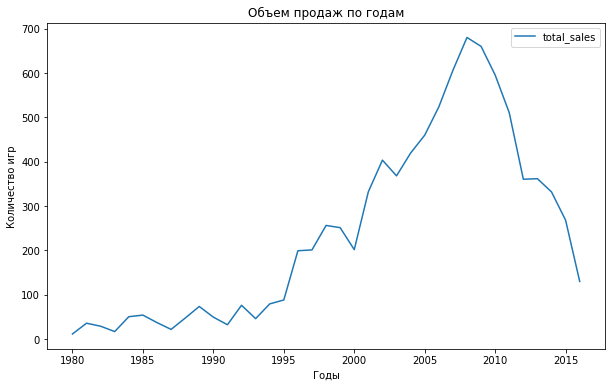

In [ ]:
games_years = df.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
plt.figure(figsize=(10,6))
sns.lineplot(data=games_years)
plt.title('Объем продаж по годам')
plt.ylabel('Количество игр')
plt.xlabel('Годы')

Рассмотрим графики количества выпущенных игр и объема продаж по годам. По ним видно, что примерно до 1995 года рынок игр был совсем небольшой. Затем наблюдается скачкообразный рост с пиком около 2008-2010 гг, а с 2011 объем рынка уменьшается. Для нас важны данные только последних лет, поэтому оставим в таблице информацию начиная с 2005 года.

In [ ]:
new_df = df[df['year_of_release'] > 2005]

### **Данные по платформам**

**Сначала изучим данные за все время.**

In [ ]:
df['platform'].value_counts().head(10)

PS2     2140
DS      2129
PS3     1320
Wii     1301
X360    1250
PSP     1203
PS      1190
PC       970
XB       817
GBA      813
Name: platform, dtype: int64

,total_sales
platform,
PS2,1247.16
X360,966.61
PS3,935.19
Wii,903.31
DS,804.28
PS,727.58
PS4,314.14
GBA,313.73
PSP,293.57


Text(0.5, 0, 'Платформа')

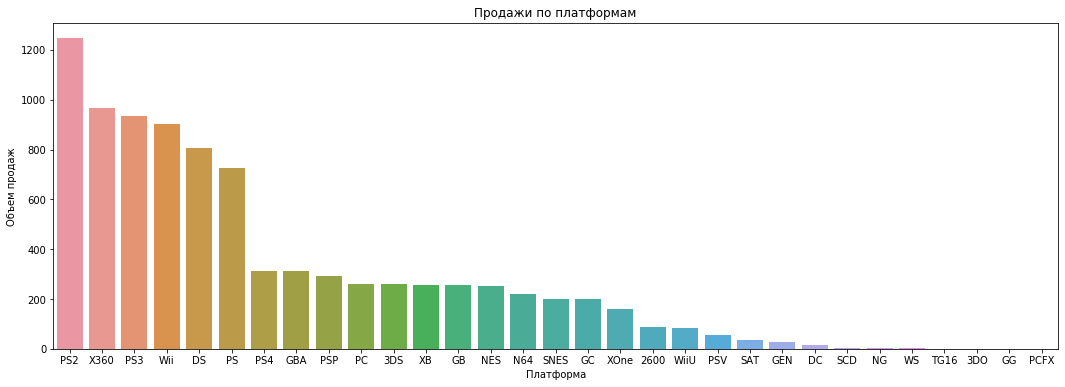

In [ ]:
sales_per_platform = df.pivot_table(index='platform', values = 'total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
display(sales_per_platform.head(10))
plt.figure(figsize = (18, 6))
sns.barplot(data=sales_per_platform, x=sales_per_platform.index, y='total_sales')
plt.title('Продажи по платформам')
plt.ylabel('Объем продаж')
plt.xlabel('Платформа')

Посмотрим сначала данные по популярности платформ за все время. Порядок мест по количеству игр и по объему продаж несколько отличаются, хотя на первом месте и там, и там стоит PS2. Также в десятку лидеров по объему продаж входит PS4, который по количеству игр еще не дотянул до лидерства. 
На основе этих данных мы можем попробовать посчитать объем продаж за игру на каждой платформе.

In [ ]:
sales_per_platform['games_quantity'] = df['platform'].value_counts()
sales_per_platform['sales_per_game'] = sales_per_platform['total_sales'] / sales_per_platform['games_quantity']

In [ ]:
display(sales_per_platform.sort_values(by='sales_per_game', ascending=False).head(10))

,total_sales,games_quantity,sales_per_game
platform,,,
GB,254.43,97,2.622990
NES,251.05,98,2.561735
GEN,28.35,27,1.050000
SNES,200.04,239,0.836987
PS4,314.14,392,0.801378
X360,966.61,1250,0.773288
2600,89.01,117,0.760769
PS3,935.19,1320,0.708477
Wii,903.31,1301,0.694320


Удивительно, но по продажам за игру вперед вышли совсем другие платформы - "старички" Gameboy и Nintendo. Наверное, как раз из-за небольшого размера рынка, отсутствия острой конкуренции и малого числа выходящих игр люди чаще покупали одинаковые игры. Сейчас же выбор намного шире.

**Теперь изучим данные по платформам только за последние указанные годы**

In [ ]:
new_df['platform'].value_counts().head(10)

DS      1987
PS3     1319
Wii     1301
X360    1229
PSP     1093
PS2      811
PC       787
3DS      515
PSV      429
PS4      392
Name: platform, dtype: int64

,total_sales
platform,
X360,957.39
PS3,935.00
Wii,903.31
DS,656.85
PS4,314.14
PS2,267.68
3DS,258.53
PSP,242.67
PC,166.46


Text(0.5, 0, 'Платформа')

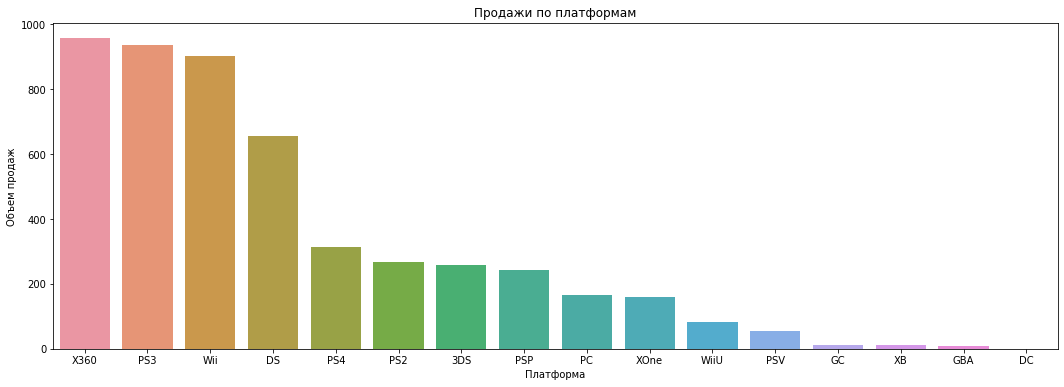

In [ ]:
new_sales_per_platform = new_df.pivot_table(index='platform', values = 'total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
display(new_sales_per_platform.head(10))
plt.figure(figsize = (18, 6))
sns.barplot(data=new_sales_per_platform, x=new_sales_per_platform.index, y='total_sales')
plt.title('Продажи по платформам')
plt.ylabel('Объем продаж')
plt.xlabel('Платформа')

In [ ]:
new_sales_per_platform['games_quantity'] = new_df['platform'].value_counts()
new_sales_per_platform['sales_per_game'] = new_sales_per_platform['total_sales'] / new_sales_per_platform['games_quantity']

In [ ]:
display(new_sales_per_platform.sort_values(by='sales_per_game', ascending=False).head(10))

,total_sales,games_quantity,sales_per_game
platform,,,
PS4,314.14,392,0.801378
X360,957.39,1229,0.778999
PS3,935.00,1319,0.708870
Wii,903.31,1301,0.694320
XOne,159.32,247,0.645020
WiiU,82.19,147,0.559116
3DS,258.53,515,0.502000
DS,656.85,1987,0.330574
PS2,267.68,811,0.330062


За последние годы лидеры как по объемам продаж, так и в продажах за игру одинаковые - X360, PS3, PS4, Wii. У PS4 пока не так много продаж, так как и игр вышло немного, но каждая игра продается хорошо. Возьмем для дальнейшей работы только 10 популярных платформ. 

In [ ]:
new_top_platforms = new_sales_per_platform.sort_values(by='total_sales', ascending=False).head(10).index.values
display(new_top_platforms)

array(['X360', 'PS3', 'Wii', 'DS', 'PS4', 'PS2', '3DS', 'PSP', 'PC',
       'XOne'], dtype=object)

Теперь посмотрим общие тенденции продаж игр на платформе по годам.

In [ ]:
new_data = new_df[new_df.platform.isin(new_top_platforms)]

Text(0.5, 0, 'Годы')

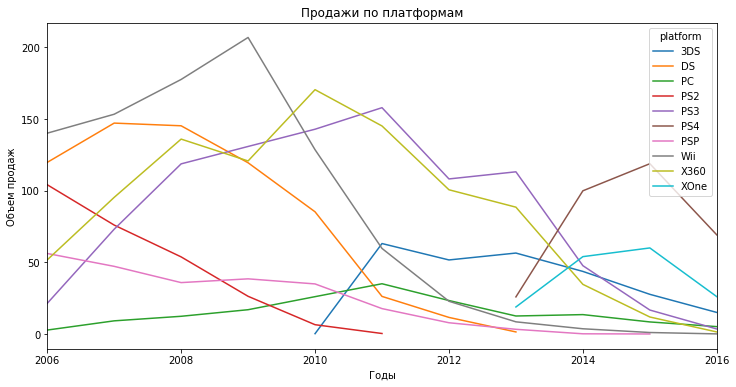

In [ ]:
new_data_pivot = new_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
new_data_pivot.plot(figsize=(12,6))
plt.title('Продажи по платформам')
plt.ylabel('Объем продаж')
plt.xlabel('Годы')

В целом мы видим тенденцию к снижению продаж, видимо, рынок находится на спаде, пользователи переходят в мобильные и онлайн-игры. "Цикл жизни" платформы - 6-9 лет. Платформы, появившиеся не так давно, еще пользуются популярностью, они еще не исчерпали свой лимит - это PS4 и XOne.

Диаграмма размаха

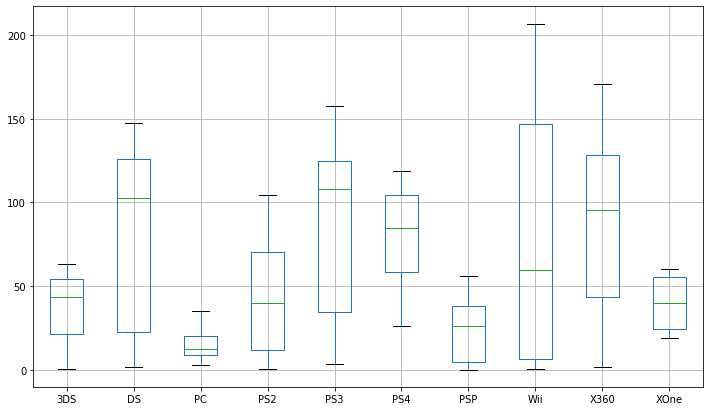

In [ ]:
new_data_pivot.boxplot(figsize=(12, 7))

[Text(0, 0.5, 'Продажи'),
 Text(0.5, 0, 'Платформа'),
 Text(0.5, 1.0, 'Объемы продаж по платформам')]

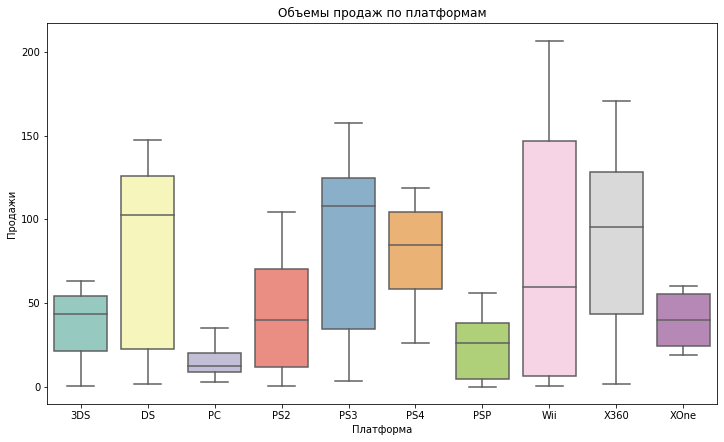

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=new_data_pivot, palette="Set3").set(xlabel='Платформа', ylabel='Продажи', title='Объемы продаж по платформам')

По диаграммам размаха видно, что платформы достаточно сильно различаются по объемам продаж. У игр на ПК, допустим, минимальный размах, объемы держатся примерно на одном уровне. У игр для Wii размах шире, а медиана тяготеет к цифре 50. Схожи продажи по размаху у DS, PS3 и X360, так как периоды и пики их популярности тоже похожи. У PS4 размах пока небольшой, так как платформа новая, но уровень медианы неплохой.

### **Влияние отзывов на продажи**

Для рассмотрения влияния отзывов на продажи возьмем сначала платформу PS3 - она достаточно долго существует, и на ее игры достаточно отзывов.

In [ ]:
PS3_data = new_data.query('platform == "PS3" and critic_score < 100 and user_score < 100')

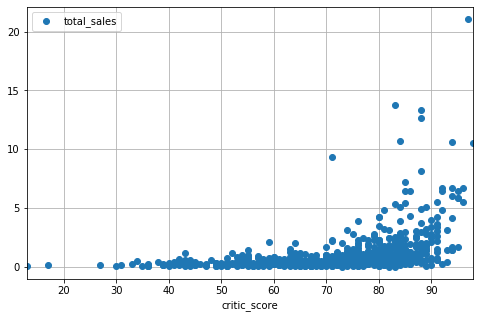

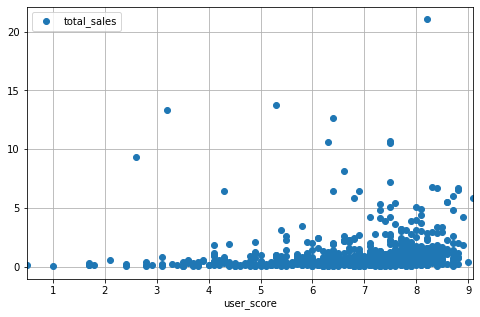

In [ ]:
PS3_data.plot(x= 'critic_score', y= 'total_sales', style='o', grid=True, figsize=(8, 5))
PS3_data.plot(x= 'user_score', y= 'total_sales', style='o', grid=True, figsize=(8, 5))

In [ ]:
print('Корреляция между объемами продаж игр на PS3 и оценками критиков:', PS3_data['total_sales'].corr(PS3_data['critic_score']))
print('Корреляция между объемами продаж игр на PS3 и оценками пользователей:', PS3_data['total_sales'].corr(PS3_data['user_score']))

Корреляция между объемами продаж игр на PS3 и оценками критиков: 0.4276431890003964
Корреляция между объемами продаж игр на PS3 и оценками пользователей: 0.14257309392034298


In [ ]:
filtered_data = new_data.query('critic_score < 100 and user_score < 100')

Есть небольшая корреляция, выше в случае оценок критиков и почти незначительная для оценок пользователей. Теперь посмотрим цифры для других платформ.

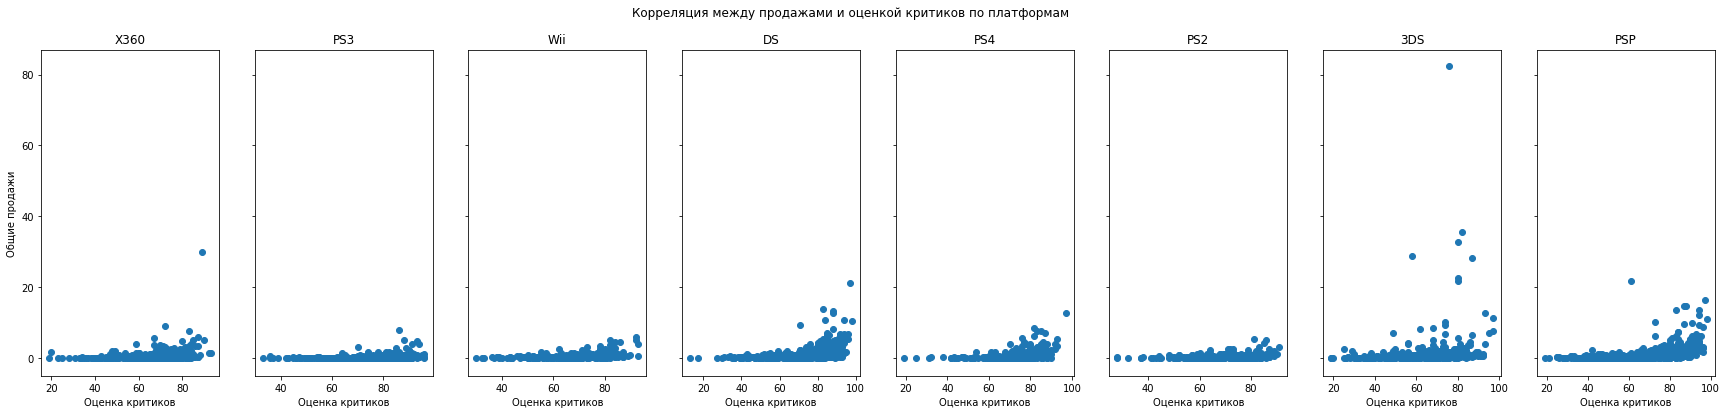

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=8, sharey=True, figsize=(30,6))
ax[0].scatter(data=filtered_data[filtered_data.platform=='DS'], x='critic_score',y='total_sales')
ax[1].scatter(data=filtered_data[filtered_data.platform=='PC'], x='critic_score',y='total_sales')
ax[2].scatter(data=filtered_data[filtered_data.platform=='PS2'], x='critic_score',y='total_sales')
ax[3].scatter(data=filtered_data[filtered_data.platform=='PS3'], x='critic_score',y='total_sales')
ax[4].scatter(data=filtered_data[filtered_data.platform=='PS4'], x='critic_score',y='total_sales')
ax[5].scatter(data=filtered_data[filtered_data.platform=='PSP'], x='critic_score',y='total_sales')
ax[6].scatter(data=filtered_data[filtered_data.platform=='Wii'], x='critic_score',y='total_sales')
ax[7].scatter(data=filtered_data[filtered_data.platform=='X360'], x='critic_score',y='total_sales')

fig.suptitle('Корреляция между продажами и оценкой критиков по платформам')
ax[0].set_ylabel('Общие продажи')
for i,e in enumerate(ax[:]):
    e.set_xlabel('Оценка критиков')
    platform_name = new_top_platforms[i]
    e.set_title(platform_name)

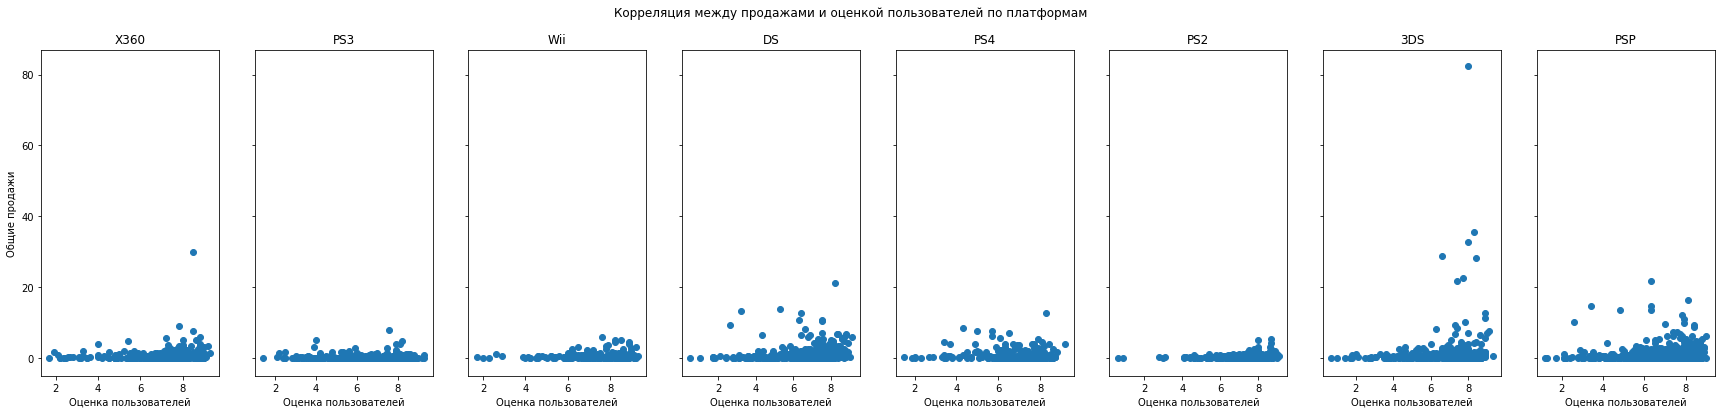

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=8, sharey=True, figsize=(30,6))
ax[0].scatter(data=filtered_data[filtered_data.platform=='DS'], x='user_score',y='total_sales')
ax[1].scatter(data=filtered_data[filtered_data.platform=='PC'], x='user_score',y='total_sales')
ax[2].scatter(data=filtered_data[filtered_data.platform=='PS2'], x='user_score',y='total_sales')
ax[3].scatter(data=filtered_data[filtered_data.platform=='PS3'], x='user_score',y='total_sales')
ax[4].scatter(data=filtered_data[filtered_data.platform=='PS4'], x='user_score',y='total_sales')
ax[5].scatter(data=filtered_data[filtered_data.platform=='PSP'], x='user_score',y='total_sales')
ax[6].scatter(data=filtered_data[filtered_data.platform=='Wii'], x='user_score',y='total_sales')
ax[7].scatter(data=filtered_data[filtered_data.platform=='X360'], x='user_score',y='total_sales')

fig.suptitle('Корреляция между продажами и оценкой пользователей по платформам')
ax[0].set_ylabel('Общие продажи')
for i,e in enumerate(ax[:]):
    e.set_xlabel('Оценка пользователей')
    platform_name = new_top_platforms[i]
    e.set_title(platform_name)

In [ ]:
for i in new_top_platforms:
  print('Корреляция между продажами и оценкой критиков для',i)
  print(filtered_data.loc[filtered_data['platform'] == i]['total_sales'].corr(filtered_data.loc[filtered_data['platform'] == i]['critic_score']))

Корреляция между продажами и оценкой критиков для X360
0.3913955752982107
Корреляция между продажами и оценкой критиков для PS3
0.4276431890003964
Корреляция между продажами и оценкой критиков для Wii
0.17081496250645148
Корреляция между продажами и оценкой критиков для DS
0.22220610152518866
Корреляция между продажами и оценкой критиков для PS4
0.40589480145836687
Корреляция между продажами и оценкой критиков для PS2
0.42693179808354875
Корреляция между продажами и оценкой критиков для 3DS
0.3384264578906769
Корреляция между продажами и оценкой критиков для PSP
0.28892444417169444
Корреляция между продажами и оценкой критиков для PC
0.2869158216373983
Корреляция между продажами и оценкой критиков для XOne
0.4104220356129637


In [ ]:
for i in new_top_platforms:
  print('Корреляция между продажами и оценкой пользователей для',i)
  print(filtered_data.loc[filtered_data['platform'] == i]['total_sales'].corr(filtered_data.loc[filtered_data['platform'] == i]['user_score']))

Корреляция между продажами и оценкой пользователей для X360
0.11061174161307452
Корреляция между продажами и оценкой пользователей для PS3
0.14257309392034298
Корреляция между продажами и оценкой пользователей для Wii
0.11142414188252159
Корреляция между продажами и оценкой пользователей для DS
0.12944307009563394
Корреляция между продажами и оценкой пользователей для PS4
-0.03362497596528878
Корреляция между продажами и оценкой пользователей для PS2
0.16820590664926705
Корреляция между продажами и оценкой пользователей для 3DS
0.2324435810781493
Корреляция между продажами и оценкой пользователей для PSP
0.24951893790296933
Корреляция между продажами и оценкой пользователей для PC
-0.023698051892689562
Корреляция между продажами и оценкой пользователей для XOne
-0.09400318326920852


Для прочих платформ тоже заметна небольшая корреляция с оценкой критиков - чем выше оценка, тем больше объем продаж. А заметного влияния от оценки пользователей не замечено.

### **Влияние жанра игры на продажи**

Созадим таблицу с суммой продаж по каждому жанру, а также построим по ней столбчатую диаграмму.

,total_sales
genre,
Action,1085.99
Sports,785.20
Shooter,711.21
Misc,538.79
Role-Playing,506.29
Racing,283.94
Platform,253.52
Simulation,220.36
Fighting,179.26


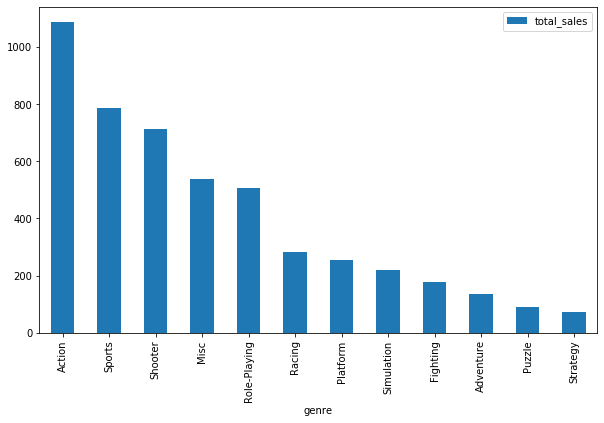

In [ ]:
genres_pivot = new_data.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
display(genres_pivot)
genres_pivot.plot(kind='bar', figsize=(10,6))

In [ ]:
genres_pivot['quantity'] = new_data['genre'].value_counts()
genres_pivot['sales_per_game'] = genres_pivot['total_sales'] / genres_pivot['quantity']
display(genres_pivot.sort_values(by='sales_per_game', ascending=False))

,total_sales,quantity,sales_per_game
genre,,,
Shooter,711.21,719,0.989166
Platform,253.52,299,0.847893
Sports,785.20,1211,0.648390
Role-Playing,506.29,898,0.563797
Racing,283.94,533,0.532720
Action,1085.99,2155,0.503940
Fighting,179.26,389,0.460823
Misc,538.79,1209,0.445649
Simulation,220.36,601,0.366656


Самые популярные игры по объему продаж - жанров экшн, спорт и шутеры. Пазлы и стратегии приносят намного меньше денег. Что касается продаж за одну игру, то прибыльнее всего шутеры, а также платформы и спорт. К анти-лидерам пазлам и стратегиям здесь присоединяются игры-приключения.

## Портрет пользователя каждого региона

### *Северная Америка*

,na_sales
platform,
X360,591.47
Wii,494.01
PS3,391.60
DS,325.06
PS2,115.75


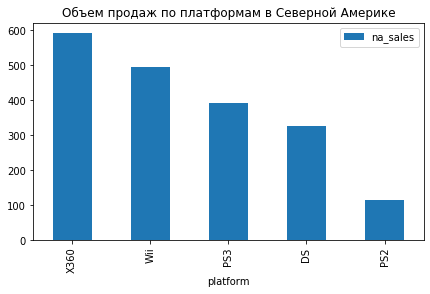

In [ ]:
na_platform_pivot = new_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
display(na_platform_pivot)
na_platform_pivot.plot(kind='bar', figsize=(7, 4), title='Объем продаж по платформам в Северной Америке')

,na_sales
genre,
Action,517.67
Sports,392.53
Shooter,370.93
Misc,278.78
Role-Playing,196.26


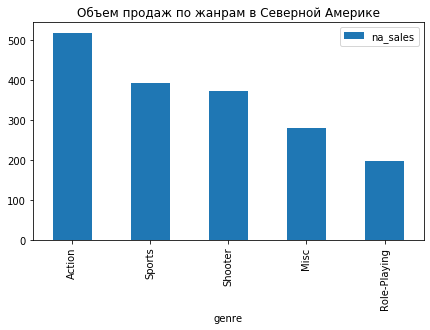

In [ ]:
na_genre_pivot = new_data.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
display(na_genre_pivot)
na_genre_pivot.plot(kind='bar', figsize=(7, 4), title='Объем продаж по жанрам в Северной Америке')

В Америке больше популярны игры для X360, Wii и PS3, а из жанров пользуются популярностью экшн, спортивные игры и шутеры. То есть, лидеры те же самые, что и по всему рынку.

### *Европа*

,eu_sales
platform,
PS3,328.83
X360,269.25
Wii,261.48
DS,143.30
PS4,141.09


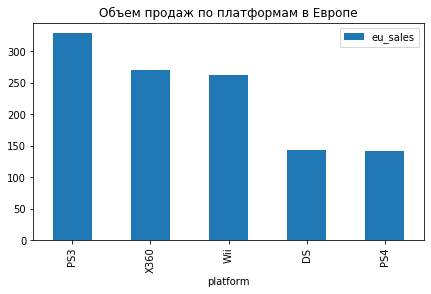

In [ ]:
eu_platform_pivot = new_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
display(eu_platform_pivot)
eu_platform_pivot.plot(kind='bar', figsize=(7, 4), title='Объем продаж по платформам в Европе')

,eu_sales
genre,
Action,342.88
Sports,248.85
Shooter,237.51
Misc,142.34
Racing,108.74


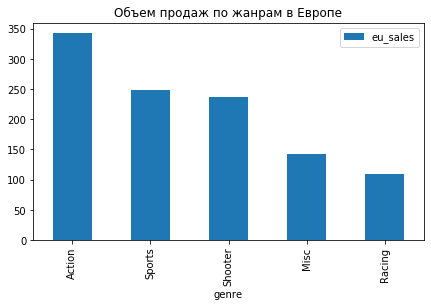

In [ ]:
eu_genre_pivot = new_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
display(eu_genre_pivot)
eu_genre_pivot.plot(kind='bar', figsize=(7, 4), title='Объем продаж по жанрам в Европе')

В Европе ситуация на рынке похожа, только среди платформ чуть большей популярностью пользуется PS3, но тройка лидеров та же: X360, Wii и PS3. Что касается жанров, то ситуация такая же, как в Америке - экшн, спорт и шутеры, только пятое место вместе ролевых игр занимают гонки.

### *Япония*

,jp_sales
platform,
DS,141.49
3DS,100.64
PS3,79.51
PSP,71.13
Wii,69.05


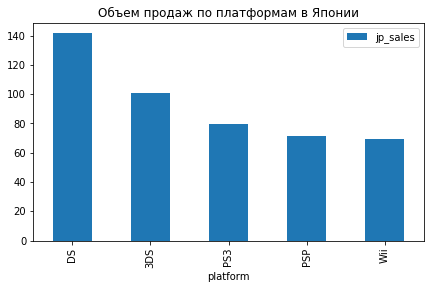

In [ ]:
jp_platform_pivot = new_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
display(jp_platform_pivot)
jp_platform_pivot.plot(kind='bar', figsize=(7,4), title='Объем продаж по платформам в Японии')

В Японии ситуация отличается - X360 не входит даже в пятерку, а лидируют DS и 3DS, также среди популярных PSP. Лидеры платформ, общие для всех трех рынков - PS3 и Wii.

,jp_sales
genre,
Role-Playing,160.88
Action,94.04
Misc,60.40
Sports,47.58
Platform,31.46


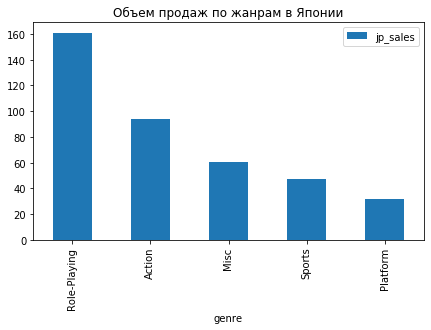

In [ ]:
jp_genre_pivot = new_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
display(jp_genre_pivot)
jp_genre_pivot.plot(kind='bar', figsize=(7,4), title='Объем продаж по жанрам в Японии')

И в жанрах Япония опять отличается - на первом месте с заметным отрывом ролевые игры, потом уже экшн и спорт. Шутеров среди лидеров нет.

### *Рейтинг ESRB*

А теперь посмотрим влияние рейтинга игр на продажи. Сначала проверим, какие значения рейтинга вообще упоминаются в датасете. Это T-Teen, M-Mature, E-Everyone, E10+-Everyone 10 up, RP - Rating pending. Больше всего игр маркированы для использования подростками и взрослыми.

In [ ]:
new_data['rating'].unique()

array(['E', 'M', nan, 'T', 'E10+', 'EC', 'RP'], dtype=object)

,eu_sales,jp_sales,na_sales,total_sales
rating,,,,
E,447.00,113.02,774.91,1494.20
M,396.84,41.58,569.51,1147.28
T,231.88,77.51,418.48,832.24
E10+,166.50,33.18,304.39,570.19
EC,0.00,0.00,1.32,1.40
RP,0.03,0.00,0.00,0.04


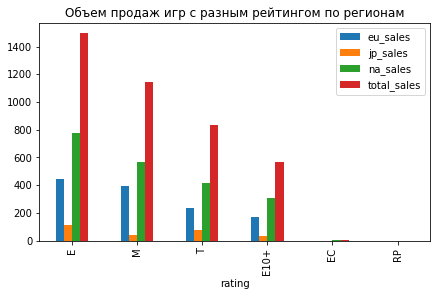

In [ ]:
total_rating_pivot = new_data.pivot_table(index='rating',
                                          values=['total_sales', 'na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')\
.sort_values(by='total_sales', ascending=False)
display(total_rating_pivot)
total_rating_pivot.plot(kind='bar', figsize=(7,4), title='Объем продаж игр с разным рейтингом по регионам')

Больше всего продаются игры с рейтингом "для всех" и "для взрослых". По странам ситуация схожа, только в Японии игры "для взрослых" продаются хуже, чем "для подростков". Да и вообще цифры продаж игр с рейтингом по Японии довольно низкие, возможно, в Японии существует своя система рейтинга, а ESRB не котируется. 

## Проверка гипотез

### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средний пользовательский рейтинг игр для платформы Xbox One равен рейтингу игр для PC}\\
   H_1 :\text{Средний пользовательский рейтинг игр для платформы Xbox One отличается от рейтинга игр для PC}
 \end{cases}
\end{equation*}$

In [ ]:
sample_xone = new_data.query('platform == "XOne" and user_score < 10').user_score.values
display(sample_xone)

array([7.9, 5.4, 6.4, 6.2, 4.1, 5.5, 7.5, 4.4, 7.2, 6.4, 4.3, 5.5, 3.1,
       6.1, 6.2, 8.2, 7.4, 5.9, 5.4, 6.9, 6.6, 7.9, 6.3, 7.5, 6.8, 5.8,
       6.4, 6.6, 8.2, 6.1, 7.3, 8. , 8. , 6.2, 6.9, 9.2, 6.1, 7.8, 8.4,
       5.9, 5.1, 5.2, 5.8, 7.7, 7.4, 5.6, 6.8, 6.2, 6.9, 5.7, 7. , 6.4,
       5.9, 7.7, 7.3, 7.4, 5.8, 7.8, 7.3, 6.7, 5.9, 5.1, 4.6, 5.1, 5.7,
       8. , 5.7, 6.8, 5.1, 7.5, 6.9, 7.8, 8.1, 6. , 6.4, 6.3, 7. , 7.8,
       7.1, 6. , 6.9, 3.2, 8.6, 7.7, 5.1, 6.6, 7.9, 6.1, 7.2, 5.5, 8.5,
       7. , 5.4, 4.3, 6.8, 5.5, 5.8, 5.3, 7.1, 5.5, 4. , 6.2, 8.3, 6.8,
       6.7, 6.8, 3.1, 7.3, 3. , 7. , 8.3, 7. , 7.2, 4.4, 7. , 6.9, 8.3,
       7.5, 8. , 7.2, 6.6, 7.3, 4.1, 7.9, 8.7, 5.7, 8. , 2.1, 8.2, 5.6,
       7.2, 6.2, 5.3, 7.5, 6. , 3.1, 7.6, 8.5, 6.8, 6.3, 5.8, 7.7, 6.9,
       8.4, 5.2, 4.9, 7.1, 7.1, 6.1, 8.1, 6.3, 6. , 8.9, 7.7, 1.6, 8. ,
       5.4, 8.1, 4.3, 7.4, 4.3, 7.1, 5.8, 4.2, 6.6, 7.3, 7.2, 7.1, 6.7,
       8.8, 7.9, 8.1, 3.1, 7.5, 6.3, 8.2, 7.1, 6.8, 6. , 8.2, 6.

In [ ]:
sample_pc = new_data.query('platform == "PC" and user_score < 10').user_score.values
display(sample_pc)

array([7.6, 4. , 8.2, 7.9, 8.1, 3.9, 5.9, 7.5, 7.9, 5.6, 4.8, 2.5, 5.3,
       7.9, 7.9, 5.2, 4.2, 8. , 7. , 2.2, 6. , 7.5, 5.4, 8.4, 7.9, 8.6,
       5.3, 8.1, 6.7, 8.5, 8. , 6.9, 7.9, 5.5, 8.2, 7.5, 8.5, 6.2, 8.2,
       5.7, 4.2, 6.6, 8.8, 7.4, 6.8, 5.9, 4.2, 9.3, 8.3, 8.2, 8. , 6.1,
       7.3, 8.6, 6.5, 7.9, 8.5, 8. , 7.7, 5.5, 4.5, 6.7, 3.6, 6.5, 8.3,
       8. , 8.2, 8.5, 8. , 6.2, 3. , 6.9, 6.8, 8.3, 8.6, 8.6, 8.6, 7.6,
       6.4, 3.6, 5.8, 5.9, 8.1, 6. , 7.3, 5.6, 8.2, 4.7, 7.6, 7.6, 5.8,
       8.5, 4.5, 5.7, 4.6, 6.6, 7.9, 8.8, 7.6, 8.1, 8.8, 6.7, 5.2, 8. ,
       5.8, 5.5, 8.5, 8. , 6.9, 8.5, 2.1, 6.3, 5.4, 8.5, 8.3, 8.7, 7.5,
       5.4, 7.5, 5.2, 6.6, 8.3, 6.2, 3.7, 4.2, 5.9, 8. , 8.1, 7.7, 8.4,
       8.1, 3.5, 7.5, 5.9, 3.3, 7.9, 7.3, 7. , 5.5, 8. , 7.3, 8.1, 7.3,
       6.8, 7.1, 6.9, 8.2, 5.6, 7.3, 8.5, 8.2, 6.8, 5.9, 6.5, 7.4, 4.4,
       6.5, 7.9, 6. , 7.4, 3.2, 6.2, 8.6, 8.6, 8.6, 4.3, 7.4, 7.2, 7.4,
       4.4, 7.1, 7. , 7.5, 3.5, 7.7, 7.8, 6. , 7.1, 4.7, 8.2, 4.

In [ ]:
alpha = .05

Уровень значимости: $\alpha = 0.05$

<B>Проверим нормальность распределения</B> несколькими способами:
1. Построив гистограмму распределения.

Text(0.5, 1.0, 'X Box One')

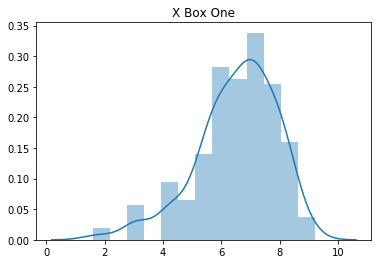

In [ ]:
sns.distplot(sample_xone).set_title('X Box One')

Text(0.5, 1.0, 'PC')

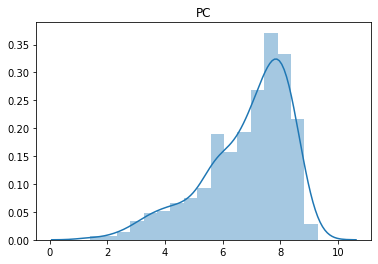

In [ ]:
sns.distplot(sample_pc).set_title('PC')

2. Построив QQ-график

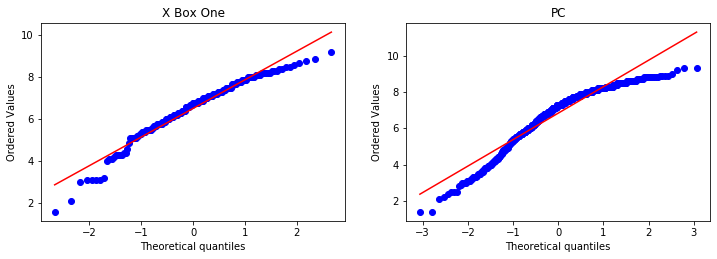

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(sample_xone, dist="norm", plot=plt)
plt.title("X Box One")
plt.subplot(2,2,2)
st.probplot(sample_pc, dist="norm", plot=plt)
plt.title("PC")
plt.show()

3. При помощи критерия Шапиро-Уилка

In [ ]:
print("Проверка по критерию Шапиро-Уилка, W-statistic: %f, p-value: %f" % st.shapiro(sample_xone))

Проверка по критерию Шапиро-Уилка, W-statistic: 0.955055, p-value: 0.000015


In [ ]:
print("Проверка по критерию Шапиро-Уилка, W-statistic: %f, p-value: %f" % st.shapiro(sample_pc))

Проверка по критерию Шапиро-Уилка, W-statistic: 0.918513, p-value: 0.000000


По всем трем методам распределение в выборках можно оценить как не нормальное, в особенности для выборки по играм на ПК. Поэтому для проверки гипотез будет корректнее использовать метод Манна-Уитни.
<BR>
Уровень значимости: $\alpha = 0.05$

Посчитаем p-value, используя тест Манна-Уитни из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [ ]:
print('Дисперсия XOne', np.var(sample_xone))
print('Дисперсия PC', np.var(sample_pc)) 

Дисперсия XOne 1.8965188383045526
Дисперсия PC 2.2963598944564096


In [ ]:
alpha = .05

results = st.mannwhitneyu(sample_xone, sample_pc, alternative='two-sided')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0004064995750682362
Отвергаем нулевую гипотезу


In [ ]:
alpha = .05

results = st.ttest_ind(
    sample_xone, 
    sample_pc,
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.008603496501781193
Отвергаем нулевую гипотезу


In [ ]:
print('Среднее значение пользовательского рейтинга игр для платформы ПК:', sample_pc.mean())
print('Среднее значение пользовательского рейтинга игр для платформы XBox One:', sample_xone.mean())

Среднее значение пользовательского рейтинга игр для платформы ПК: 6.83594249201278
Среднее значение пользовательского рейтинга игр для платформы XBox One: 6.521428571428572


Отвергаем нулевую гипотезу, значит, средние пользовательские рейтинги этих двух платформ отличаются друг от друга. Вычисления по средним значениям это также подтверждают - рейтинги схожи, но не одинаковы.

### Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средний пользовательский рейтинг игр жанра Action равен рейтингу игр жанра Sports}\\
   H_1 :\text{Ссредний пользовательский рейтинг игр жанра Action отличается от рейтинга игр жанра Sports}
 \end{cases}
\end{equation*}$

In [ ]:
sample_action = new_data.query('genre == "Action" and user_score < 10').user_score.values
display(sample_action)

array([8.2, 8.1, 8.3, ..., 5.1, 6.7, 7.6])

In [ ]:
sample_sports = new_data.query('genre == "Sports" and user_score < 10').user_score.values
display(sample_sports)

array([8. , 8. , 7.7, 7.4, 4.3, 5. , 4.3, 7.4, 5.7, 8. , 8.2, 8.9, 4.5,
       4.2, 8.7, 6.7, 7.9, 7.9, 7.6, 7.5, 4.4, 5.9, 6.5, 6.3, 7.2, 4.2,
       6.8, 5.8, 6.1, 3.2, 5.9, 5.7, 5.5, 8. , 7.7, 7.5, 8. , 7.5, 7.8,
       5.5, 7. , 4.9, 5.4, 8. , 7. , 6.1, 6.8, 6.1, 6.4, 5.5, 6.8, 6.2,
       6.5, 8.6, 6.7, 6.9, 5.5, 5.6, 6.1, 5.4, 5.2, 6.7, 4.9, 7.1, 5.5,
       7.6, 8. , 7.8, 4.4, 6.7, 4.1, 6. , 4.9, 7.1, 6.3, 8.4, 8.6, 7.8,
       8.5, 8. , 8.7, 3. , 8. , 6.1, 8.1, 2.9, 6.4, 5.7, 8.1, 6.7, 8. ,
       7. , 2.7, 6.5, 8.7, 7.4, 8.9, 7.9, 3.5, 7.5, 6. , 7.6, 8.4, 7.2,
       2. , 8.1, 5.8, 8.4, 6.8, 6.4, 5.9, 7.8, 7.4, 5.4, 8.4, 7.6, 5.8,
       6.7, 7.9, 5.1, 7.5, 8.8, 8. , 7.7, 5.8, 8. , 7.3, 7.8, 8.8, 7. ,
       6.1, 7.9, 6.1, 7. , 6.2, 6.6, 6.8, 6.2, 7.2, 7.6, 5.1, 5.3, 6.9,
       7.6, 3.2, 6.7, 4.5, 8.9, 6.2, 8.6, 7.1, 7.8, 7.5, 5.4, 5.7, 6.8,
       8.1, 5.2, 6.7, 7.3, 8.4, 6.8, 7.3, 8.3, 8.1, 7. , 7.4, 7.8, 7.8,
       6.2, 7.2, 6.6, 5.8, 6.7, 7.6, 7.6, 5.9, 6.9, 4.6, 5.8, 5.

In [ ]:
alpha = .05

Уровень значимости: $\alpha = 0.05$

<B>Проверим нормальность распределения</B> несколькими способами:
1. Построив гистограмму распределения.

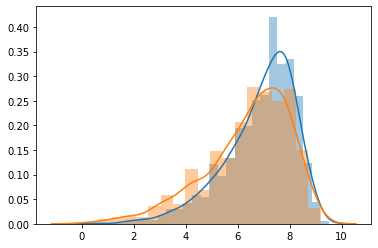

In [ ]:
sns.distplot(sample_action);
sns.distplot(sample_sports);

2. Построив QQ-график

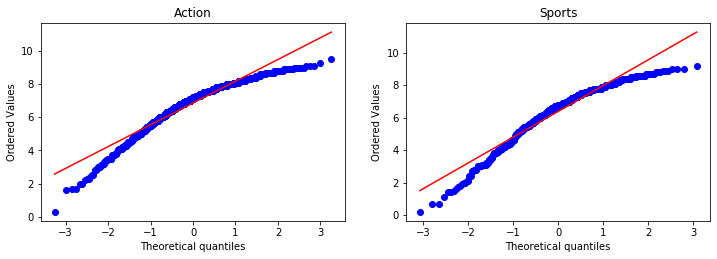

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(sample_action, dist="norm", plot=plt)
plt.title("Action")
plt.subplot(2,2,2)
st.probplot(sample_sports, dist="norm", plot=plt)
plt.title("Sports")
plt.show()

In [ ]:
print("Проверка по критерию Шапиро-Уилка, W-statistic: %f, p-value: %f" % st.shapiro(sample_action))

Проверка по критерию Шапиро-Уилка, W-statistic: 0.934491, p-value: 0.000000


In [ ]:
print("Проверка по критерию Шапиро-Уилка, W-statistic: %f, p-value: %f" % st.shapiro(sample_sports))

Проверка по критерию Шапиро-Уилка, W-statistic: 0.936726, p-value: 0.000000


По всем трем методам распределение в выборках можно оценить как не нормальное. Поэтому для проверки гипотез будет корректнее использовать метод Манна-Уитни.

<BR>
Уровень значимости: $\alpha = 0.05$

<B>Посчитаем p-value</B>, используя тест Манна-Уитни из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [ ]:
print('Дисперсия Action', np.var(sample_action))
print('Дисперсия Sports', np.var(sample_sports)) 

Дисперсия Action 1.8393261173392408
Дисперсия Sports 2.6827172886244814


In [ ]:
alpha = 0.05
results = st.mannwhitneyu(sample_action, sample_sports, alternative='two-sided')
print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  6.3120187077688165e-09
Отвергаем нулевую гипотезу


In [ ]:
results = st.ttest_ind(
    sample_action, 
    sample_sports,
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  7.545627005061331e-10
Отвергаем нулевую гипотезу


In [ ]:
print('Среднее значение пользовательского рейтинга игр для жанра Action:', sample_action.mean())
print('Среднее значение пользовательского рейтинга игр для жанра Sports:', sample_sports.mean())

Среднее значение пользовательского рейтинга игр для жанра Action: 6.8606997558991045
Среднее значение пользовательского рейтинга игр для жанра Sports: 6.393488372093022


Эту нулевую гипотезу мы отвергаем, значит, подтверждается гипотеза, что пользовательские рейтинги игр жанров Action и Sports разные. Это видно и по вычисленным нами средним значениям.

## Общий вывод

<B>Для анализа данных я использовала датафрейм </B> с информацией по 16715 игре, первая из которых вышла 1980 году, а последняя - в 2016 г. Эти игры созданы для использования на 31 платформе, самыми популярными из которых стали PS2 и XBOX360. Также для игр предоставлены объемы продаж на рынках Северной Америки, Европы, Японии и прочих стран. В таблице довольно много пропусков в столбцах с оценками критиков и пользователей, а также с рейтингом игр по рекомендуемому возрасту. 

<B>В результате анализа данных обнаружено следующее:</B> 
- Средний срок популярности платформы - около 6 лет, пик длится 2-3 года. В настоящее время еще распространены игры для платформы PS4, а также Xbox One и Wii, на них и следует сделать упор при продвижении. 
- В продажах игр для ПК нет заметных пиков или падений, они продаются примерно одинаково уже около 20 лет, их тоже можно учитывать при составлении стратегии.
- В целом, рынок игр находится на спаде, что связано с ростом игр для мобильных устройств. Возможно, стоит рассмотреть переход в эту сферу.
- На продажи сильнее влияют оценки критиков, чем оценки пользователей, но в целом корреляция между продажами и отзывами не сильная. 
- Лучше всего продаются игры жанров экшн, спорт и шутеры. 
- Рынки Северной Америки и Европы схожи между собой по предпочтительным платформам и жанрам (X360, Wii, PS3 среди платформ, и Action, Sports и Shooter в жанрах), а рынок Японии отличается - там предпочитают DS и 3DS, а из жанров - Role-Playing и Action. 
- При планировании рекламных кампаний стоит выбирать игры для PS4 и ПК жанров Action, Shooter и Sports, получившие отличные оценки от критиков. Следует учитывать отличие японского рынка от остального мира.